# 第二章-局部图像描述子
该章主旨：寻找图像间的对应点和对应区域

该章介绍：图像匹配的两种局部描述子算法

应用：创建全景图、增强现实技术以及计算图像的三维重建

## Harris角点检测器

Harris角点检测器——角点检测算法

角点：极值点，即在某方面属性特别突出的点。

主要思想：如果像素周围存在多于一个方向的边，该点为兴趣点，称该点为角点。

图像域中点X上的对称正半定矩阵$M_I=M_I(x)$定义为：


$\boldsymbol{M}_{I}=\nabla \boldsymbol{I} \nabla \boldsymbol{I}^{T}=\left[\begin{array}{c}{\boldsymbol{I}_{x}} \\ {\boldsymbol{I}_{y}}\end{array}\right]\left[\begin{array}{ll}{\boldsymbol{I}_{x}} & {\boldsymbol{I}_{y}}\end{array}\right]=\left[\begin{array}{cc}{\boldsymbol{I}_{x}^{2}} & {\boldsymbol{I}_{x} \boldsymbol{I}_{y}} \\ {\boldsymbol{I}_{x} \boldsymbol{I}_{y}} & {\boldsymbol{I}_{y}^{2}}\end{array}\right]$

$\nabla \boldsymbol{I}$：包含$I_x$,$I_y$的图像梯度。

1.梯度的大小：$\lvert\nabla I\lvert= \sqrt{I_x^2+I_y^2}$

它描述了图像强度变化的强弱

2.梯度的角度：$\alpha=\arctan2(I_x\;,I_y)$

它描述了图像中在每个点（像素）上强度变化最大的方向。NumPy中的arctan2()函数返回弧度表示的有符号角度，角度的变化区间为−π...π。


由于以上定义，$M_I$的秩为1，特征值为$\lambda_{1}=|\nabla I|^{2}$和$\lambda_{2}=0$，对于图像的每一个像素，都可以计算出该矩阵。

<mark>Harris矩阵:$\overline{M}_{I}$<mark>

选择权重矩阵W（通常为高斯滤波器$G_\sigma$）,可以得到卷积:$$\overline{\boldsymbol{M}}_{I}=\boldsymbol{W} * \boldsymbol{M}_{I}$$

卷积之后得到$M_1$在周围像素上的局部平均。

矩阵W：像素X周围的感兴趣区域

在区域附近对矩阵$M_I$取平均的原因：特征值会依赖于局部图像特性而变化。

如果图像的梯度在该区域变化，那么$M_I$的第二个特征值将不再为0。如果图像的梯度没有变化，$M_I$的特征值也不会变化。


取决于该区域$I$的值，Harris矩阵$M_I$的特征值有三种情况：

• 如果$\lambda_{1}$和$\lambda_{2}$都是很大的正数，则该$x$点为角点；

• 如果$\lambda_{1}$很大，$\lambda_{2} \approx 0$，则该区域内存在一个边，该区域内的平均$M_I$的特征值不会变化太大；

• 如果$\lambda_{1} \approx \lambda_{2} \approx 0$，该区域内为空。

在不需要实际计算特征值的情况下，为了把重要的情况和其他情况分开，Harris 和 Stephens引入了指示函数：$$\operatorname{det}\left(\overline{\boldsymbol{M}}_{i}\right)-\kappa \operatorname{trace}\left(\overline{\boldsymbol{M}}_{i}\right)^{2}$$

其中trace函数用于求二维方阵的迹，即该方阵对角线上元素之和

为了去除加权常数$K$，我们通常使用商数：$$\frac{\operatorname{det}\left(\overline{\boldsymbol{M}}_{I}\right)}{\operatorname{trace}\left(\overline{\boldsymbol{M}}_{I}\right)^{2}}$$
作为指示器。

写Harris 角点检测程序，需要使用 scipy.ndimage.filters 模块中的高斯导数滤波器来计算导数。

返场介绍：$ G_\sigma $表示标准差为$ \sigma $的二维高斯核，定义为：$ G_\sigma = \frac{1}{2\pi\sigma^2}e^{\frac{-(x^2+y^2)}{2\sigma}} $

使用高斯滤波器是为了在角点检测过程中抑制噪声强度。

首先，将角点响应函数添加到 harris.py 文件中，该函数使用高斯导数实现。

同样地，参数$\sigma$定义了使用的高斯滤波器的尺度大小。你也可以修改这个函数，对 x 和y 方向上不同的尺度参数，以及尝试平均操作中的不同尺度，来计算 Harris 矩阵。


In [3]:
from scipy.ndimage import filters
def compute_harris_response(im,sigma=3): 
    """ 在一幅灰度图像中，对每个像素计算 Harris 角点检测器响应函数 """
    # 计算导数
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    #sigma为高斯核函数的标准差
    #0阶对应于与高斯核的卷积，正阶对应于与高斯函数导数的卷积
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
    # 计算 Harris 矩阵的分量
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)
    # 计算特征值和迹
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet / Wtr

上面的函数返回像素值为 Harris 响应函数值的一幅图像。

现在，我们需要从这幅图像中挑选出需要的信息，然后选取像素值高于阈值的所有图像点；接着，限定角点之间的间隔必须大于设定的最小距离。

这种方法会产生很好的角点检测结果。

为了实现该算法，我们获取所有的候选像素点，以角点响应值递减的顺序排序，然后将距离已标记为角点位置过近的区域从候选像素点中删除。

将下面的函数添加到 harris.py 文件中：

In [ ]:
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """ 从一幅 Harris 响应图像中返回角点。min_dist 为分割角点和图像边界的最少像素数目 """
    # 寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # 得到候选点的坐标
    coords = np.array(harrisim_t.nonzero()).T
    # 以及它们的 Harris 响应值
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    # 对候选点按照 Harris 响应值进行排序
    index = np.argsort(candidate_values)
    #argsort函数返回的是数组值从小到大的索引值
    # 将可行点的位置保存到数组中
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    # 按照 min_distance 原则，选择最佳 Harris 点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                              (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    return filtered_coords

以上为检测图像中角点所需要的所有函数。
下面函数作用为显示图像中的角点，将其添加到 harris.py 文件中，如下：

In [ ]:
def plot_harris_points(image,filtered_coords): 
    """ 绘制图像中检测到的角点 """
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    plt.axis('off')
    plt.show()

首先，打开该图像，转换成灰度图像。然后，计算响应函数，基于响应值选择角点。
最后，在原始图像中覆盖绘制检测出的角点。绘制出的结果图像如下图所示：

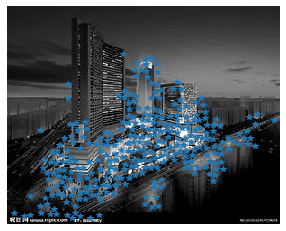

In [13]:
import harris
import numpy as np
from PIL import Image
path = r'D:/学习文件/CV/test_jpg/'
im = np.array(Image.open(path+'build.jpg').convert('L'))
harrisim = harris.compute_harris_response(im)
#对每个像素计算 Harris 角点检测器响应函数
filtered_coords = harris.get_harris_points(harrisim,6)
#从一幅 Harris 响应图像中返回角点
harris.plot_harris_points(im, filtered_coords)
#显示图像角点

### 在图像间寻找对应点

比较图像间的兴趣点来寻找匹配角点：加入描述子信息，并给出一个比较兴趣点描述子的方法。

**兴趣点描述子**：分配给兴趣点的一个向量，描述该点附近的图像的表观信息。描述子越好，寻找到的对应点越好。

我们用**对应点**或者**点**的对应来描述相同物体和场景点在不同图像上形成的像素点。

Harris 角点的描述子通常是由周围图像像素块的灰度值，以及用于比较的归一化互相关矩阵构成的。图像的像素块由以该像素点为中心的周围矩形部分图像再成。

通常，两个（相同大小）像素块 $I_1(x)$ 和 $I_2(x)$ 的相关矩阵定义为：$$c\left(\boldsymbol{I}_{1}, \boldsymbol{I}_{2}\right)=\sum_{\mathbf{x}} f\left(\boldsymbol{I}_{1}(\mathbf{x}), \boldsymbol{I}_{2}(\mathbf{x})\right)$$

其中，函数 f 随着相关方法的变化而变化。上式取像素块中所有像素位置$x$的和。
对于互相关矩阵，函数$f(I_1，I_2)=I_1I_2$, 因此，$c(I_1，I_2)=I_1 · I_2$。$c(I_1，I_2)$ 的值越大，像素块$I_1$和$I_2$的相似度越高。

归一化的互相关矩阵是互相关矩阵的一种变形，可以定义为：$$\operatorname{ncc}\left(\boldsymbol{I}_{1}, \boldsymbol{I}_{2}\right)=\frac{1}{n-1} \sum_{\mathbf{x}} \frac{\left(\boldsymbol{I}_{1}(\mathbf{x})-\mu_{1}\right)}{\sigma_{1}} \cdot \frac{\left(\boldsymbol{I}_{2}(\mathbf{x})-\mu_{2}\right)}{\sigma_{2}}$$

其中,$n$为像素块中像素的数目,$μ_1$ 和$μ_2$表示每个像素块中的平均像素值强度，$\sigma_1$和$\sigma_2$分别表示每个像素块中的标准差。通过减去均值和除以标准差，该方法对图像亮度变化具有**稳健性**。

为获取图像像素块，并使用归一化的互相关矩阵来比较它们，需要下面两个函数，并它们添加到 harris.py 文件中。

In [ ]:
def get_descriptors(image,filtered_coords,wid=5): 
    """ 对于每个返回的点，返回点周围 2*wid+1 个像素的值（假设选取点的 min_distance > wid）"""
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
              coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    return desc

**image**：奇数大小长度的方形灰度图像块，该图像块的中心为处理的像素点。该函数将图像块像素值压平成一个向量，然后添加到描述子列表中

In [ ]:
def match(desc1,desc2,threshold=0.5):   
    """ 对于第一幅图像中的每个角点描述子，使用归一化互相关，选取它在第二幅图像中的匹配角点 """
    n = len(desc1[0])
    # 点对的距离
    d = -np.ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
            ncc_value = np.sum(d1 * d2) / (n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value
                ndx = np.argsort(-d)
                matchscores = ndx[:,0]
    return matchscores

以上函数使用**归一化的互相关矩阵**，将每个描述子匹配到另一个图像中的最优的候选点。

由于数值较高的距离代表两个点能够更好地匹配，所以在排序之前，我们对距离取相反数。

下面的函数可以实现获得更稳定的匹配：

我们从第二幅图像向第一幅图像匹配，然后过滤掉在两种方法中不都是最好的匹配。

In [ ]:
def match_twosided(desc1,desc2,threshold=0.5):
    """ 两边对称版本的 match()"""
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    ndx_12 = where(matches_12 >= 0)[0]
    # 去除非对称的匹配
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12

这些匹配可以通过在两边分别绘制出图像，使用线段连接匹配的像素点来直观地可视化。

下面的代码可以实现匹配点的可视化。并将这两个函数添加到 harris.py 文件中：

In [2]:
def appendimages(im1,im2):
    """ 返回将两幅图像并排拼接成的一幅新图像 """
    # 选取具有最少行数的图像，然后填充足够的空行
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # 如果这些情况都没有，那么它们的行数相同，不需要进行填充
    return np.concatenate((im1,im2), axis=1)

In [1]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ 显示一幅带有连接匹配之间连线的图片
    输入：im1，im2（数组图像），locs1，locs2（特征位置），matchscores（match() 的输出），
    show_below（如果图像应该显示在匹配的下方）"""
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = np.vstack((im3,im3))
        plt.imshow(im3)
        cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    plt.axis('off')      

下图为使用归一化的互相关矩阵来寻找对应点的例子。

starting matching


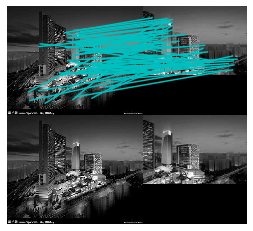

In [7]:
import harris
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

path = r'D:/学习文件/CV/test_jpg/'
im1 = np.array(Image.open(path+'build.jpg').convert('L'))
im2 = np.array(Image.open(path+'build2.jpg').convert('L'))
wid = 5

harrisim = harris.compute_harris_response(im1,5)#计算 Harris 角点检测器响应函数

filtered_coords1 = harris.get_harris_points(harrisim,wid+1)#从Harris 响应图像中返回角点

d1 = harris.get_descriptors(im1,filtered_coords1,wid)#返回描述子列表

harrisim = harris.compute_harris_response(im2,5)
filtered_coords2 = harris.get_harris_points(harrisim,wid+1)
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = harris.match_twosided(d1,d2)#去除非对称的匹配

plt.figure()
plt.gray()
harris.plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)#显示一幅带有连接匹配之间连线的图片
plt.show()

因为，与现代的一些方法相比，图像像素块的互相关矩阵具有较弱的描述性，该算法的结果存在一些不正确匹配。

实际运用中，我们通常使用更稳健的方法来处理这些对应匹配。

这些描述符还有一个问题，它们**不具有**尺度不变性和旋转不变性，而算法中像素块的大小也会影响对应匹配的结果。

旋转不变性：只要对特征定义了方向，然后在同一个方向上进行特征描述就可以实现旋转不变性。

尺度不变性：为了实现尺度不变性，需要给特征加上尺度因子。在进行特征描述的时候，将尺度统一就可以实现尺度不变性了。

所谓的旋转不变性和尺度不变性的原理，就是我们在描述一个特征之前，将两张图像都变换到同一个方向和同一个尺度上，然后再在这个统一标准上来描述这个特征。同样的，如果在描述一个特征之前，将图像变换到同一个仿射尺度或者投影尺度上，那么就可以实现仿射不变性和投影不变性。